# GD_05

## 1. CAM

### 1.1 Module

In [1]:
import os
import cv2
import copy
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [3]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [36]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
  beta = (1.0 - alpha)
  merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
  return merged_image

In [7]:
tf.__version__

'2.8.2'

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
drive.mount('/gdrive')

Mounted at /gdrive


### 1.2 Data

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ["train", "test"],
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8KS8J5/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8KS8J5/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


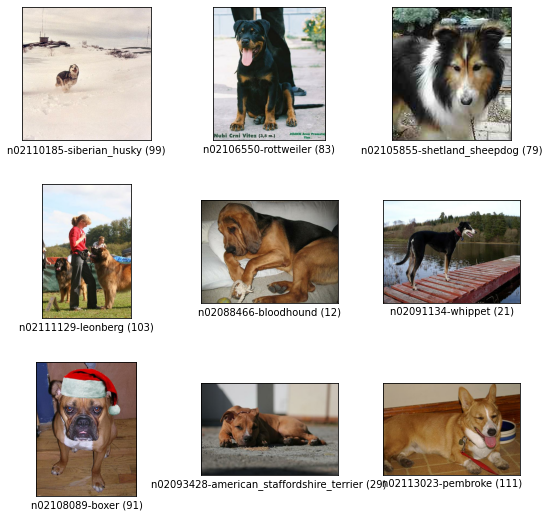

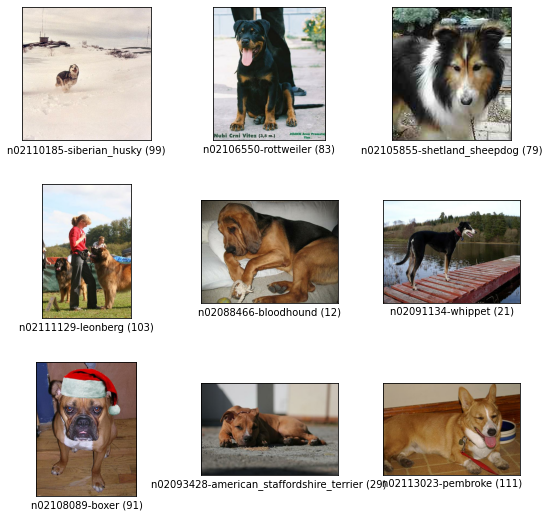

In [11]:
tfds.show_examples(ds_train, ds_info)

In [12]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

108


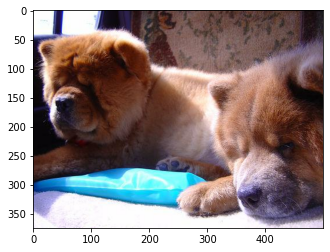

In [13]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 1.3 Model

In [14]:
num_classes = ds_info.features['label'].num_classes
base_model  = keras.applications.resnet.ResNet50(
    include_top = False,         # Imagenet 분류기에서 fully connected layer 제거하기
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    pooling = 'avg'          # GAP(Global Average Pooling)를 적용시키기
)

x = base_model.output
preds = keras.layers.Dense(num_classes, activation = "softmax")(x)
cam = keras.Model(inputs = base_model.input, outputs = preds)

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
cam.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 1.4 CAM

#### 1.4.1 Train

In [17]:
cam.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics = ['accuracy'],
)


In [18]:
history_cam = cam.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 110s 123ms/step - loss: 2.1967 - accuracy: 0.4501 - val_loss: 3.4335 - val_accuracy: 0.1889
Epoch 2/10
750/750 [==============================] - 90s 120ms/step - loss: 0.7511 - accuracy: 0.7930 - val_loss: 1.1221 - val_accuracy: 0.6725
Epoch 3/10
750/750 [==============================] - 90s 120ms/step - loss: 0.2254 - accuracy: 0.9513 - val_loss: 0.9272 - val_accuracy: 0.7188
Epoch 4/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0553 - accuracy: 0.9959 - val_loss: 0.9363 - val_accuracy: 0.7281
Epoch 5/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0349 - accuracy: 0.9978 - val_loss: 0.9300 - val_accuracy: 0.7344
Epoch 6/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0158 - accuracy: 0.9994 - val_loss: 0.9121 - val_accuracy: 0.7424
Epoch 7/10
750/750 [==============================] - 90s 120ms/step - loss: 0.0095 - accuracy: 0.9998 - val_loss: 0.9231 - val_a

In [19]:
cam_path = '/gdrive/MyDrive/Colab Notebooks/CAM/model/cam_0.h5'
cam.save(cam_path)

#### 1.4.2 Predict

40


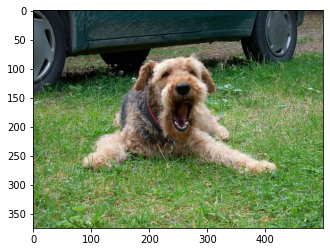

In [20]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

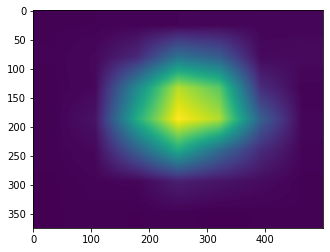

In [21]:
cam_image = generate_cam(cam, item)
plt.imshow(cam_image)
plt.show()

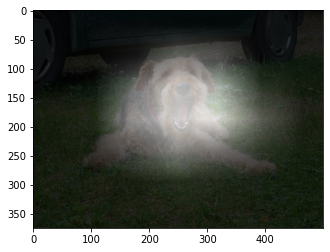

In [35]:
origin_image = item['image'].astype(np.uint8)
cam_image_2 = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(origin_image, cam_image_2, 0.2)
plt.imshow(blended_image)
plt.show()

### 1.5 Grad-CAM

In [37]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

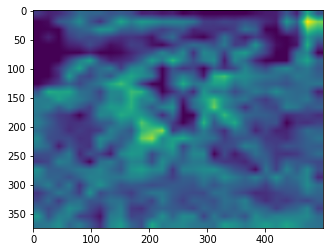

In [38]:
grad_cam_image_1 = generate_grad_cam(cam, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_1)
plt.show()

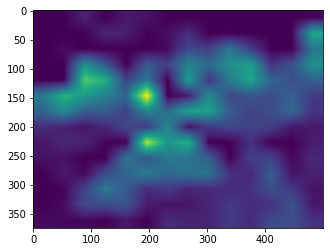

In [39]:
grad_cam_image_2 = generate_grad_cam(cam, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_2)
plt.show()

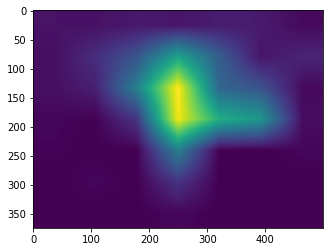

In [40]:
grad_cam_image_3 = generate_grad_cam(cam, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_3)
plt.show()

#### 1.5.1 Bounding Box

108


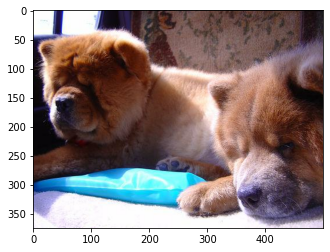

In [41]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

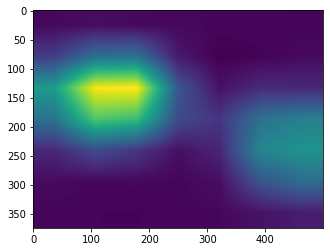

In [42]:
cam_image = generate_cam(cam, item)
plt.imshow(cam_image)
plt.show()

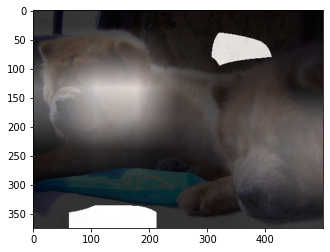

In [43]:
origin_image = item['image'].astype(np.uint8)
cam_image_2 = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(origin_image, cam_image_2, 0.2)
plt.imshow(blended_image)
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect = get_bbox(cam_image)
rect

array([[ 75,  68],
       [402,   3],
       [452, 254],
       [126, 319]])

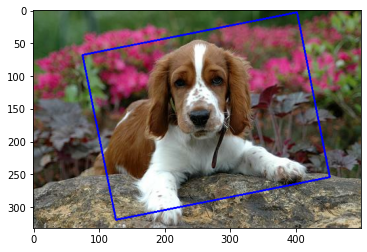

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### 1.5.2 IoU

In [ ]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.009036144578313253, 0.15, 0.9608433734939759, 0.904]

In [ ]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7545380122310268

## 2. Retrospect

##### 1) Explainable AI
- AI의 예측 과정에서 어떤 부분을 보고 분류를 하는지 등의 의문이 있었는데  
CAM을 통해 대략적으로 알 수 있어서 좋았습니다.

## 3. References

##### 1) Grad-CAM
- https://medium.com/@aimldl1984/explainable-ai-grad-cam-8acd04dd2dd3
- https://jsideas.net/grad_cam/

##### 2) Tensorflow
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
- https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature
- https://www.tensorflow.org/datasets/catalog/stanford_dogs

##### 3) CV2
- https://webnautes.tistory.com/1245